In [ ]:
pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    preds = model.predict(img_array)
    decoded_preds = decode_predictions(preds, top=5)[0]
    return decoded_preds

if __name__ == "__main__":
    img_path = '/content/istockphoto-1420676204-612x612.jpg'
    predictions = classify_image(img_path)

    print("Predictions:")
    for i, (imagenet_id, label, score) in enumerate(predictions):
        print(f"{i + 1}: {label} ({score:.2f})")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predictions:
1: tiger (0.78)
2: tiger_cat (0.19)
3: zebra (0.01)
4: jaguar (0.01)
5: tabby (0.00)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from nltk.tokenize import word_tokenize
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define Text Encoder (simple LSTM for text to feature vector)
class TextEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text_input):
        x = self.embedding(text_input)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Use the last LSTM output
        text_features = self.fc(lstm_out)
        return text_features

# Define the Generator (Simple CNN + ResNet as feature extractor)
class Generator(nn.Module):
    def __init__(self, z_dim, text_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + text_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 3 * 64 * 64)  # Assuming image size 64x64
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.eval()  # Freeze ResNet

    def forward(self, z, text_features):
        x = torch.cat((z, text_features), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(-1, 3, 64, 64)  # Reshape to image dimensions
        return x

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(128*16*16, 1)

    def forward(self, img):
        x = F.relu(self.conv1(img))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.sigmoid(self.fc(x))
        return x

# Load and preprocess the text input
def preprocess_text(text, vocab):
    tokens = word_tokenize(text.lower())
    token_indices = [vocab[word] if word in vocab else vocab['<UNK>'] for word in tokens]
    return torch.tensor(token_indices).unsqueeze(0)  # Shape: (1, sequence_length)

# Initialize models
z_dim = 100
text_dim = 256  # Embedding size of the text
vocab = {'<UNK>': 0, 'dog': 1, 'running': 2, 'field': 3}  # Simple vocabulary for illustration

text_encoder = TextEncoder(input_dim=len(vocab), embedding_dim=128, hidden_dim=256, output_dim=text_dim)
generator = Generator(z_dim=z_dim, text_dim=text_dim)
discriminator = Discriminator()

# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train the GAN (simplified loop)
def train_gan(num_epochs=100):
    for epoch in range(num_epochs):
        # Generate random noise
        z = torch.randn(16, z_dim)

        # Preprocess a sample text input
        text_input = preprocess_text("A dog running in a field", vocab)
        text_features = text_encoder(text_input)

        # Generate fake image
        fake_img = generator(z, text_features)

        # Discriminator forward pass
        real_img = torch.randn(16, 3, 64, 64)  # Dummy real image (replace with real data)
        real_labels = torch.ones(16, 1)
        fake_labels = torch.zeros(16, 1)

        real_preds = discriminator(real_img)
        fake_preds = discriminator(fake_img.detach())

        # Compute discriminator loss
        d_loss_real = criterion(real_preds, real_labels)
        d_loss_fake = criterion(fake_preds, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Update Discriminator
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Generator forward pass
        fake_preds = discriminator(fake_img)
        g_loss = criterion(fake_preds, real_labels)

        # Update Generator
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Training the model
train_gan(num_epochs=100)

# Generate and display an image
def generate_and_display_image(text_input):
    z = torch.randn(1, z_dim)
    text_input = preprocess_text(text_input, vocab)
    text_features = text_encoder(text_input)
    generated_img = generator(z, text_features)
    generated_img = generated_img.squeeze().detach().numpy().transpose(1, 2, 0)

    plt.imshow((generated_img + 1) / 2)  # Rescale to [0, 1] for display
    plt.axis('off')
    plt.show()

# Generate and display an image from the description
generate_and_display_image("A dog running in a field")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from nltk.tokenize import word_tokenize # This line uses the downloaded 'punkt' resource
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ... (rest of the code remains the same) ...

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/100], D Loss: 1.3800688982009888, G Loss: 0.6412832140922546
Epoch [10/100], D Loss: 0.737414538860321, G Loss: 0.7447198033332825
Epoch [20/100], D Loss: 0.7211605310440063, G Loss: 0.938181459903717
Epoch [30/100], D Loss: 0.6556885838508606, G Loss: 2.565380334854126
Epoch [40/100], D Loss: 0.56329745054245, G Loss: 3.096609592437744
Epoch [50/100], D Loss: 0.5567864775657654, G Loss: 1.9136241674423218
Epoch [60/100], D Loss: 0.7046070694923401, G Loss: 1.6607329845428467
Epoch [70/100], D Loss: 0.8473727107048035, G Loss: 2.127779722213745
Epoch [80/100], D Loss: 1.3761518001556396, G Loss: 2.71968936920166
Epoch [90/100], D Loss: 0.9445952773094177, G Loss: 1.6355621814727783


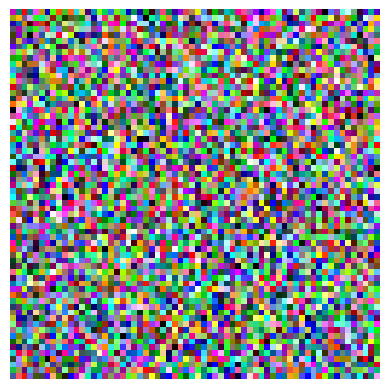

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text_input):
        x = self.embedding(text_input)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Use the last LSTM output
        text_features = self.fc(lstm_out)
        return text_features

# Define the Generator (Simple CNN + ResNet as feature extractor)
class Generator(nn.Module):
    def __init__(self, z_dim, text_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + text_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 3 * 64 * 64)  # Assuming image size 64x64
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.eval()  # Freeze ResNet

    def forward(self, z, text_features):
        x = torch.cat((z, text_features), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(-1, 3, 64, 64)  # Reshape to image dimensions
        return x

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(128*16*16, 1)

    def forward(self, img):
        x = F.relu(self.conv1(img))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.sigmoid(self.fc(x))
        return x

# Load and preprocess the text input
def preprocess_text(text, vocab):
    tokens = word_tokenize(text.lower())
    token_indices = [vocab[word] if word in vocab else vocab['<UNK>'] for word in tokens]
    return torch.tensor(token_indices).unsqueeze(0)  # Shape: (1, sequence_length)

# Initialize models
z_dim = 100
text_dim = 256  # Embedding size of the text
vocab = {'<UNK>': 0, 'dog': 1, 'running': 2, 'field': 3}  # Simple vocabulary for illustration

text_encoder = TextEncoder(input_dim=len(vocab), embedding_dim=128, hidden_dim=256, output_dim=text_dim)
generator = Generator(z_dim=z_dim, text_dim=text_dim)
discriminator = Discriminator()

# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train the GAN (simplified loop)
def train_gan(num_epochs=100):
    for epoch in range(num_epochs):
        # Generate random noise
        z = torch.randn(16, z_dim)

        # Preprocess a sample text input
        # Preprocess a sample text input and repeat it 16 times
        text_input = preprocess_text("A dog running in a field", vocab).repeat(16, 1)
        text_features = text_encoder(text_input)

        # Generate fake image
        fake_img = generator(z, text_features)

        # Discriminator forward pass
        real_img = torch.randn(16, 3, 64, 64)  # Dummy real image (replace with real data)
        real_labels = torch.ones(16, 1)
        fake_labels = torch.zeros(16, 1)

        real_preds = discriminator(real_img)
        fake_preds = discriminator(fake_img.detach())

        # Compute discriminator loss
        d_loss_real = criterion(real_preds, real_labels)
        d_loss_fake = criterion(fake_preds, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Update Discriminator
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Generator forward pass
        fake_preds = discriminator(fake_img)
        g_loss = criterion(fake_preds, real_labels)

        # Update Generator
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Training the model
train_gan(num_epochs=100)

# Generate and display an image
def generate_and_display_image(text_input):
    z = torch.randn(1, z_dim)
    text_input = preprocess_text(text_input, vocab)
    text_features = text_encoder(text_input)
    generated_img = generator(z, text_features)
    generated_img = generated_img.squeeze().detach().numpy().transpose(1, 2, 0)

    plt.imshow((generated_img + 1) / 2)  # Rescale to [0, 1] for display
    plt.axis('off')
    plt.show()

# Generate and display an image from the description
generate_and_display_image("A dog running in a field")
